# Alphavec Example - Walk-Forward Analysis

This notebook demonstrates running `alphavec.walk_forward()` for fold-based performance analysis.

Walk-forward analysis splits data into consecutive time folds and computes metrics for each fold independently. This helps assess strategy robustness across different market regimes and provides statistical aggregates (median, mean, std) across folds.

Install the optional dependencies to run this notebook: `pip install -r requirements.dev.txt`

In [1]:
from pathlib import Path

from IPython.display import HTML, display
import pandas as pd

from alphavec import (
    MarketData,
    MetricKey,
    SimConfig,
    walk_forward,
    FoldConfig,
    tearsheet,
)

## Load Data

In [2]:
data_dir = Path("./data")

weights = pd.read_feather(data_dir / "weights.feather")
close_prices = pd.read_feather(data_dir / "close_prices.feather")
open_prices = pd.read_feather(data_dir / "open_prices.feather")
funding_rates = pd.read_feather(data_dir / "funding_rates.feather")

display(weights.tail())
display(close_prices.tail())

symbols = weights.columns.tolist()
print("assets", len(symbols))
print("start", weights.index.min())
print("end", weights.index.max())

symbol,AAVE,ADA,AI,AI16Z,AIXBT,ALT,ANIME,APE,APT,AR,...,ZEN,ZEREBRO,ZK,ZORA,ZRO,kBONK,kFLOKI,kNEIRO,kPEPE,kSHIB
ts,,,,,,,,,,,,,,,,,,,,,
2025-12-02 00:00:00+00:00,NaN,-0.031875,NaN,NaN,NaN,NaN,NaN,NaN,-0.097401,0.029260,...,NaN,NaN,NaN,0.0,NaN,-0.008459,NaN,NaN,-0.000699,NaN
2025-12-03 00:00:00+00:00,NaN,-0.027453,NaN,NaN,NaN,NaN,NaN,NaN,-0.083888,0.025201,...,-0.112875,NaN,NaN,0.0,0.000131,0.000000,NaN,NaN,0.000000,NaN
2025-12-04 00:00:00+00:00,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,-0.086195,0.025894,...,-0.115978,NaN,NaN,0.0,0.000135,NaN,NaN,NaN,NaN,NaN
2025-12-05 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.053187,0.015978,...,-0.071529,NaN,0.0,0.0,0.000083,NaN,NaN,NaN,NaN,NaN
2025-12-06 00:00:00+00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.051574,0.000000,...,-0.069359,NaN,0.0,NaN,0.000081,NaN,NaN,NaN,NaN,NaN


symbol,AAVE,ADA,AI,AI16Z,AIXBT,ALT,ANIME,APE,APT,AR,...,ZEN,ZEREBRO,ZK,ZORA,ZRO,kBONK,kFLOKI,kNEIRO,kPEPE,kSHIB
ts,,,,,,,,,,,,,,,,,,,,,
2025-12-02 00:00:00+00:00,168.79,0.38834,NaN,NaN,0.039585,0.013016,0.006575,0.23618,1.8922,3.9386,...,9.6541,0.028973,0.033617,0.048958,1.3000,0.008721,0.043165,0.11868,0.004023,0.007918
2025-12-03 00:00:00+00:00,197.87,0.44952,NaN,NaN,0.043865,0.013717,0.006534,0.25134,2.0184,4.2969,...,9.4366,0.038904,0.038245,0.050670,1.4093,0.010014,0.049838,0.14077,0.004803,0.008968
2025-12-04 00:00:00+00:00,190.48,0.43922,NaN,NaN,0.043271,0.013139,0.006329,0.23680,1.9350,4.1867,...,9.5340,0.037351,0.037513,0.048951,1.3982,0.009621,0.047621,0.13732,0.004764,0.008697
2025-12-05 00:00:00+00:00,183.37,0.41582,NaN,NaN,0.040539,0.012715,0.006519,0.23167,1.7443,4.0007,...,8.6429,0.038500,0.033500,0.047205,1.3706,0.009068,0.044926,0.13049,0.004387,0.008298
2025-12-06 00:00:00+00:00,187.32,0.41342,NaN,NaN,0.042355,0.013159,0.006486,0.23631,1.7555,4.0015,...,8.5287,0.034134,0.033014,0.047661,1.3989,0.009380,0.046659,0.14057,0.004512,0.008415


assets 151
start 2023-01-01 00:00:00+00:00
end 2025-12-06 00:00:00+00:00


## Align Data

In [3]:
weights = weights.sort_index()

# Simulate requires that all given dataframes have the same index and columns as close_prices
assert weights.index.equals(close_prices.index)
assert weights.columns.equals(close_prices.columns)

# Use next-period open as the execution price to avoid lookahead.
exec_prices = open_prices.shift(-1)

## Run Walk-Forward Analysis

Walk-forward analysis splits the simulation period into consecutive folds and runs independent simulations on each.

**Configure folds with `FoldConfig`:**
```python
FoldConfig(
    fold_period="3ME",   # 3-month folds (use "6ME", "1YE" for other periods)
    min_periods=30,      # Minimum observations per fold
    align_start=True,    # Align to calendar boundaries
)
```

**Access full-period metrics (unified API):**
```python
# These methods delegate to full_result
result.metric_value(MetricKey.ANNUALIZED_SHARPE)
result.available_metrics("Performance")
result.metrics_dict("Risk")
```

**Access fold-level aggregated metrics:**
```python
# Get aggregation object for a metric
agg = result.metric_aggregation(MetricKey.ANNUALIZED_SHARPE)
print(agg.median, agg.mean, agg.std, agg.min, agg.max)

# Get per-fold values as a Series
fold_sharpes = result.fold_metric_values(MetricKey.ANNUALIZED_SHARPE)

# Get summary stats DataFrame
stats = result.summary_stats([MetricKey.ANNUALIZED_SHARPE, MetricKey.MAX_DRAWDOWN_EQUITY_PCT])
```

**Access per-fold results:**
```python
for fold in result.folds:
    print(f"Fold {fold.fold_index}: {fold.start_period} to {fold.end_period}")
    print(f"  Sharpe: {fold.result.metric_value(MetricKey.ANNUALIZED_SHARPE):.2f}")
```

In [4]:
result = walk_forward(
    weights=weights,
    market=MarketData(
        close_prices=close_prices,
        exec_prices=exec_prices,
        funding_rates=funding_rates,
    ),
    config=SimConfig(
        benchmark_asset="BTC",
        order_notional_min=10,
        fee_rate=0.00025,      # 2.5 bps per trade
        slippage_rate=0.001,   # 10 bps per trade
        trim_warmup=True,
        start_period="2023-01-01",
        end_period="2025-12-06",
        init_cash=10_000,
        freq_rule="1D",
        trading_days_year=365,
        risk_free_rate=0.03,
    ),
    fold_config=FoldConfig(
        fold_period="3ME",   # 3-month (quarterly) folds
        min_periods=30,      # Require at least 30 days per fold
        align_start=True,    # Align to calendar quarters
    ),
    include_full_result=True,
)

print(f"Generated {len(result.folds)} folds")

# Extract full-period metrics using the unified API (delegates to full_result)
print(f"Full simulation Sharpe: {result.metric_value(MetricKey.ANNUALIZED_SHARPE):.3f}")
print(f"Full simulation Return: {result.metric_value(MetricKey.TOTAL_RETURN_PCT):.2f}%")

Generated 9 folds
Full simulation Sharpe: 1.900
Full simulation Return: 373.58%


## Per-Fold Results

In [5]:
# Display per-fold metrics
print("Per-Fold Performance:")
print("-" * 80)
for fold in result.folds:
    sharpe = fold.result.metric_value(MetricKey.ANNUALIZED_SHARPE)
    ret = fold.result.metric_value(MetricKey.TOTAL_RETURN_PCT)
    dd = fold.result.metric_value(MetricKey.MAX_DRAWDOWN_EQUITY_PCT)
    print(
        f"Fold {fold.fold_index:2d}: {fold.start_period.strftime('%Y-%m-%d')} to {fold.end_period.strftime('%Y-%m-%d')} | "
        f"Sharpe: {sharpe:7.3f} | Return: {ret:7.2f}% | MaxDD: {dd:7.2f}%"
    )

Per-Fold Performance:
--------------------------------------------------------------------------------
Fold  0: 2023-08-31 to 2023-11-29 | Sharpe:  -0.288 | Return:   -1.39% | MaxDD:  -19.51%
Fold  1: 2023-11-30 to 2024-02-28 | Sharpe:  -0.149 | Return:   -0.09% | MaxDD:  -17.20%
Fold  2: 2024-02-29 to 2024-05-30 | Sharpe:   5.109 | Return:   26.90% | MaxDD:  -13.25%
Fold  3: 2024-05-31 to 2024-08-30 | Sharpe:  -1.489 | Return:  -21.19% | MaxDD:  -27.51%
Fold  4: 2024-08-31 to 2024-11-29 | Sharpe:   6.819 | Return:   43.97% | MaxDD:   -9.72%
Fold  5: 2024-11-30 to 2025-02-27 | Sharpe:   6.621 | Return:   35.44% | MaxDD:   -8.27%
Fold  6: 2025-02-28 to 2025-05-30 | Sharpe:  -0.413 | Return:   -2.19% | MaxDD:  -19.50%
Fold  7: 2025-05-31 to 2025-08-30 | Sharpe:   4.514 | Return:   29.01% | MaxDD:  -10.37%
Fold  8: 2025-08-31 to 2025-11-29 | Sharpe:   7.108 | Return:   66.57% | MaxDD:  -12.76%


## Aggregated Metrics Across Folds

In [6]:
# Get summary statistics for key metrics
key_metrics = [
    MetricKey.ANNUALIZED_SHARPE,
    MetricKey.ANNUALIZED_RETURN_PCT,
    MetricKey.MAX_DRAWDOWN_EQUITY_PCT,
    MetricKey.TOTAL_RETURN_PCT,
    MetricKey.HIT_RATE,
    MetricKey.CALMAR_RATIO,
]

stats_df = result.summary_stats(key_metrics)
display(stats_df)

,Metric,Median,Mean,Std,Min,Max,Count
0,Annualized Sharpe,4.514170,3.092463,3.601419,-1.489275,7.107791,9
1,Annualized return %,1.735181,1.659600,2.224925,-0.562141,6.378162,9
2,Max drawdown (equity) %,-13.250635,-15.343115,6.162221,-27.513060,-8.265402,9
3,Total return %,26.898958,19.670736,27.747942,-21.186719,66.570998,9
4,Hit rate,0.527473,0.525455,0.059441,0.455556,0.640449,9
5,Calmar ratio,13.935047,15.747329,18.789481,-2.043181,49.989316,9


In [7]:
# Extract specific aggregation details
sharpe_agg = result.metric_aggregation(MetricKey.ANNUALIZED_SHARPE)

print("Sharpe Ratio Analysis Across Folds:")
print(f"  Median Sharpe: {sharpe_agg.median:.3f}")
print(f"  Mean Sharpe:   {sharpe_agg.mean:.3f}")
print(f"  Std Sharpe:    {sharpe_agg.std:.3f}")
print(f"  Min Sharpe:    {sharpe_agg.min:.3f}")
print(f"  Max Sharpe:    {sharpe_agg.max:.3f}")
print(f"  Valid Folds:   {sharpe_agg.count}")
print()

# Compare median fold performance to full period using unified API
full_sharpe = result.metric_value(MetricKey.ANNUALIZED_SHARPE)  # delegates to full_result
print(f"Full Period Sharpe: {full_sharpe:.3f}")
print(f"Median Fold Sharpe: {sharpe_agg.median:.3f}")

# Get all performance metrics from full result using unified API
print("\nFull Period Performance Metrics:")
for key, value in result.metrics_dict("Performance").items():
    print(f"  {key}: {value}")

Sharpe Ratio Analysis Across Folds:
  Median Sharpe: 4.514
  Mean Sharpe:   3.092
  Std Sharpe:    3.601
  Min Sharpe:    -1.489
  Max Sharpe:    7.108
  Valid Folds:   9

Full Period Sharpe: 1.900
Median Fold Sharpe: 4.514

Full Period Performance Metrics:
  Annualized return %: 0.9548321790455192
  Annualized volatility: 0.48666710934667534
  Annualized Sharpe: 1.9003383653500996
  Max drawdown (equity) %: -30.015971434336365
  Total return %: 373.5785176331631
  Total return: 37357.851763316314


## Summary DataFrame

In [8]:
# The summary DataFrame contains all per-fold metrics
summary = result.summary
display(summary[["fold_index", "start_period", "end_period", "n_periods", MetricKey.ANNUALIZED_SHARPE, MetricKey.TOTAL_RETURN_PCT]])

,fold_index,start_period,end_period,n_periods,Annualized Sharpe,Total return %
0,0,2023-08-31 00:00:00+00:00,2023-11-29 00:00:00+00:00,91,-0.287846,-1.385629
1,1,2023-11-30 00:00:00+00:00,2024-02-28 00:00:00+00:00,91,-0.149189,-0.092795
2,2,2024-02-29 00:00:00+00:00,2024-05-30 00:00:00+00:00,92,5.109450,26.898958
3,3,2024-05-31 00:00:00+00:00,2024-08-30 00:00:00+00:00,92,-1.489275,-21.186719
4,4,2024-08-31 00:00:00+00:00,2024-11-29 00:00:00+00:00,91,6.819201,43.967581
5,5,2024-11-30 00:00:00+00:00,2025-02-27 00:00:00+00:00,90,6.620571,35.442237
6,6,2025-02-28 00:00:00+00:00,2025-05-30 00:00:00+00:00,92,-0.412701,-2.192843
7,7,2025-05-31 00:00:00+00:00,2025-08-30 00:00:00+00:00,92,4.514170,29.014841
8,8,2025-08-31 00:00:00+00:00,2025-11-29 00:00:00+00:00,91,7.107791,66.570998


In [9]:
# Get per-fold metric values as a Series for further analysis
fold_sharpes = result.fold_metric_values(MetricKey.ANNUALIZED_SHARPE)
fold_returns = result.fold_metric_values(MetricKey.TOTAL_RETURN_PCT)

print("Per-fold Sharpe values:")
print(fold_sharpes)
print()
print(f"Positive Sharpe folds: {(fold_sharpes > 0).sum()} / {len(fold_sharpes)}")

Per-fold Sharpe values:
0   -0.287846
1   -0.149189
2    5.109450
3   -1.489275
4    6.819201
5    6.620571
6   -0.412701
7    4.514170
8    7.107791
Name: Annualized Sharpe, dtype: float64

Positive Sharpe folds: 5 / 9


## Generate Tearsheets

You can generate tearsheets for the full simulation period or for individual folds.

,Category,Value,Note
Metric,,,
Period frequency,Meta,1D,Interpretation: Sampling frequency used for annualization. Smaller periods are generally more granular (but can be noisier).
Benchmark Asset,Meta,BTC,Interpretation: Column name of the benchmark asset used for alpha/beta and benchmark charts (if provided).
Fee %,Meta,0.00025,Interpretation: Trading fee rate applied to order notional (decimal units; e.g. 0.001 = 10 bps).
Slippage %,Meta,0.001,Interpretation: Slippage applied against the trader on execution prices (decimal units; e.g. 0.001 = 10 bps).
Init Cash,Meta,10000.0,Interpretation: Initial cash (starting equity) used for the simulation.
Trading Days Year,Meta,365,Interpretation: Trading days per year used for annualization.
Risk Free Rate,Meta,0.03,Interpretation: Annual risk-free rate used for Sharpe/Sortino (decimal units).
Simulation start date,Meta,2023-08-09 00:00:00+00:00,Interpretation: First timestamp in the simulation index. Earlier start dates generally make estimates more statistically stable.
Simulation end date,Meta,2025-12-06 00:00:00+00:00,Interpretation: Last timestamp in the simulation index. More recent end dates generally better reflect current market conditions.

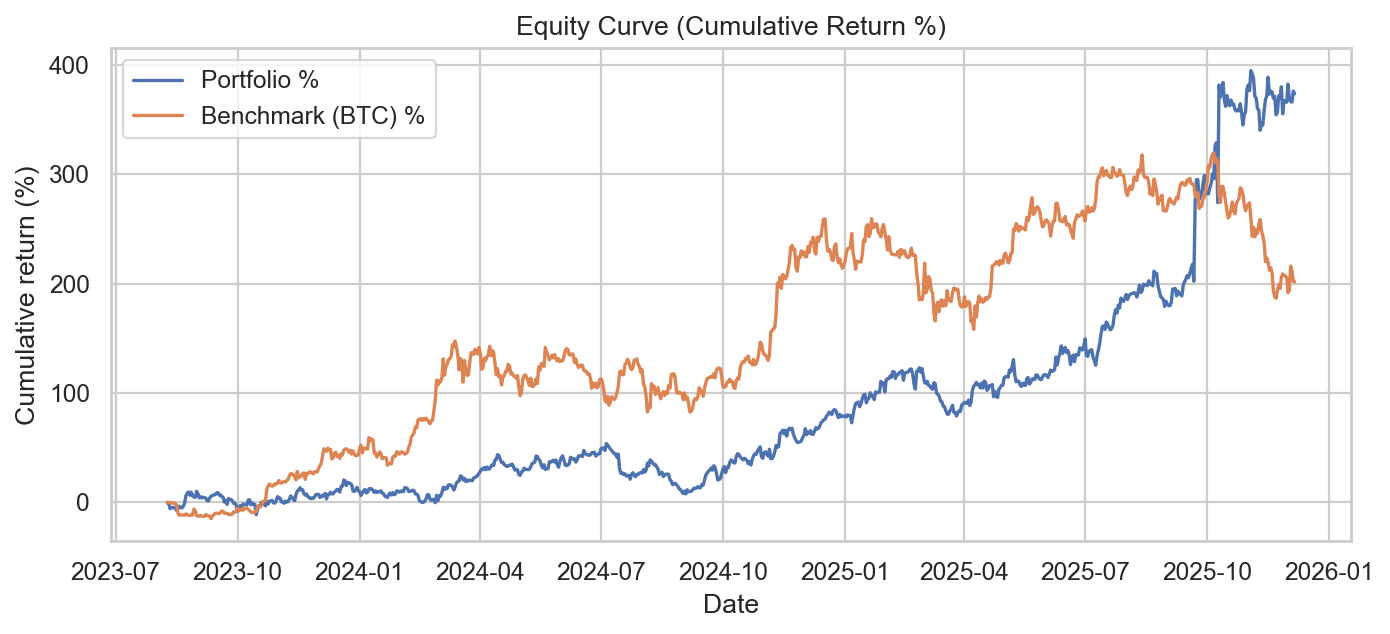
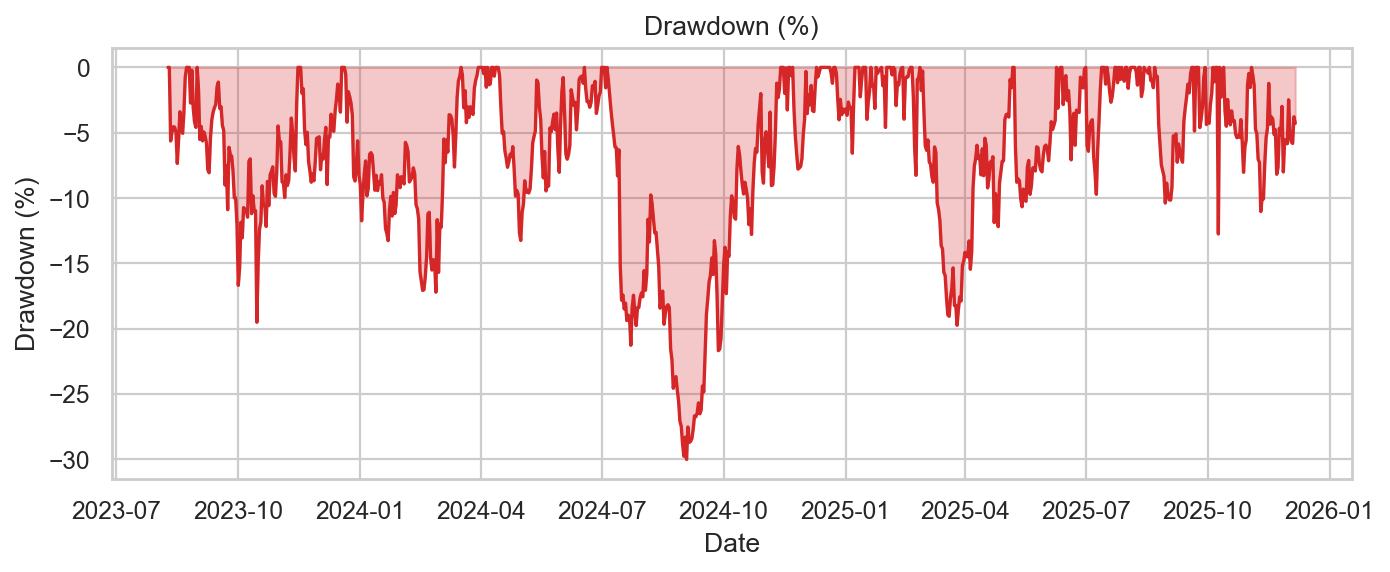
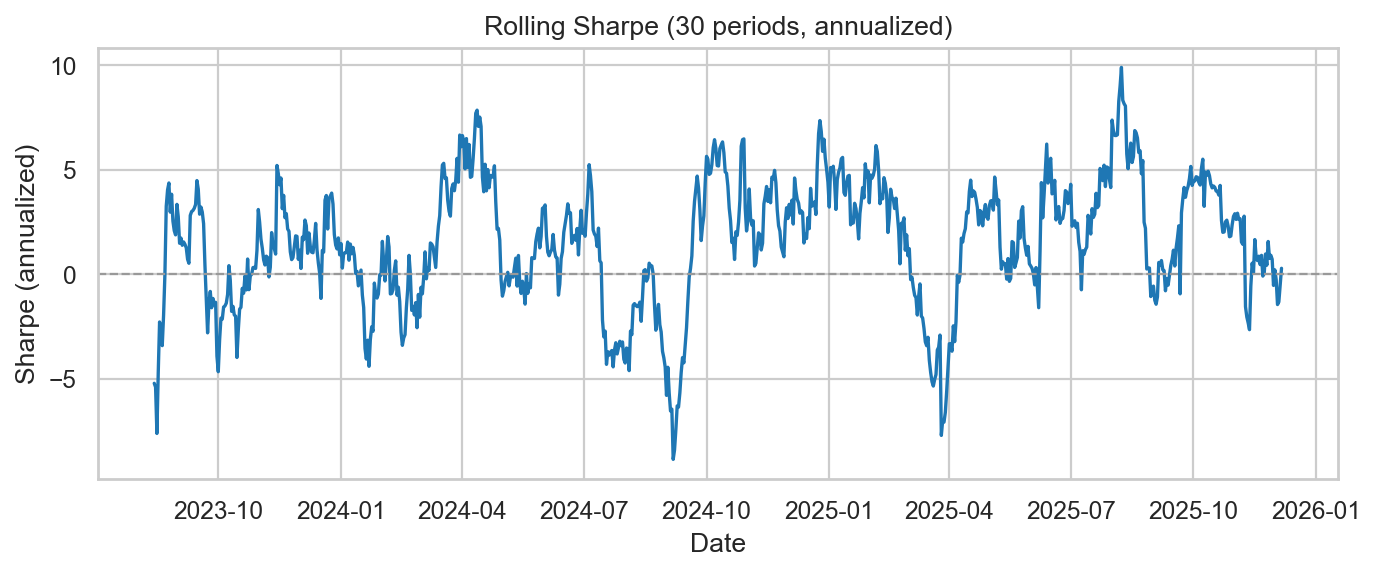
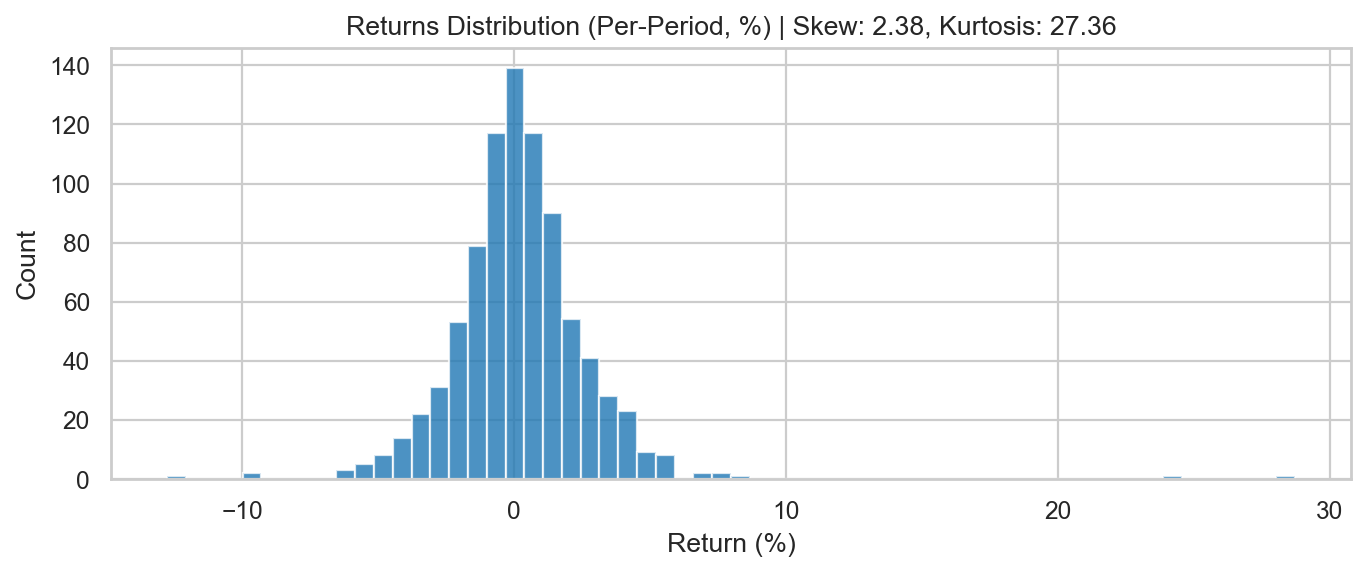
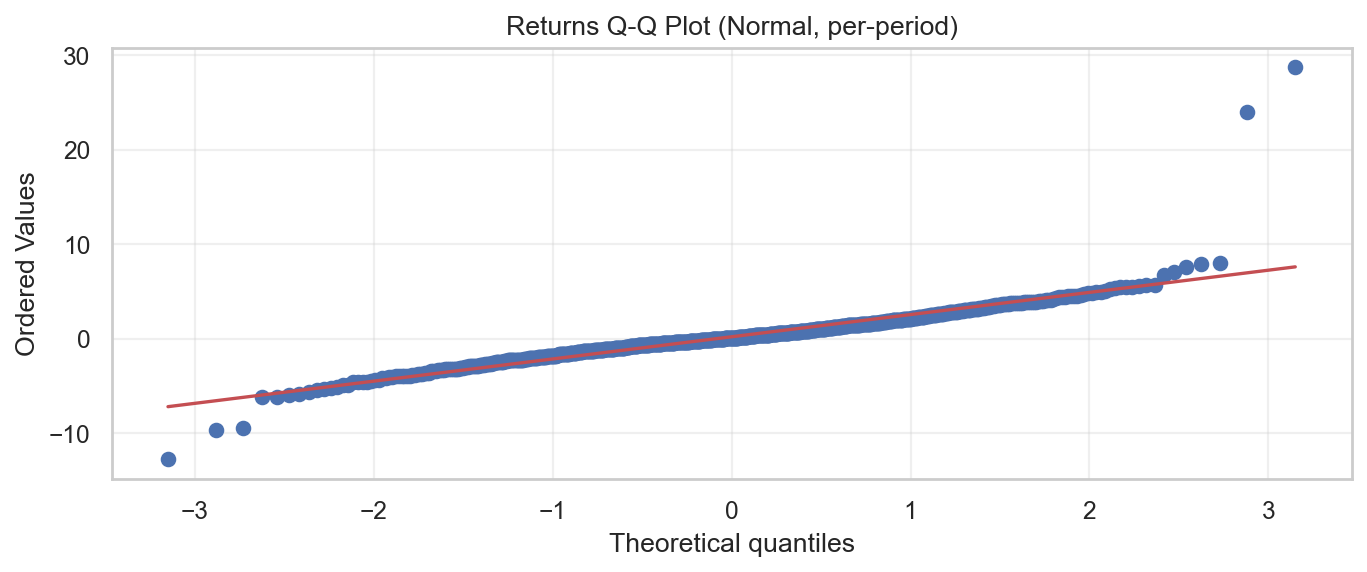
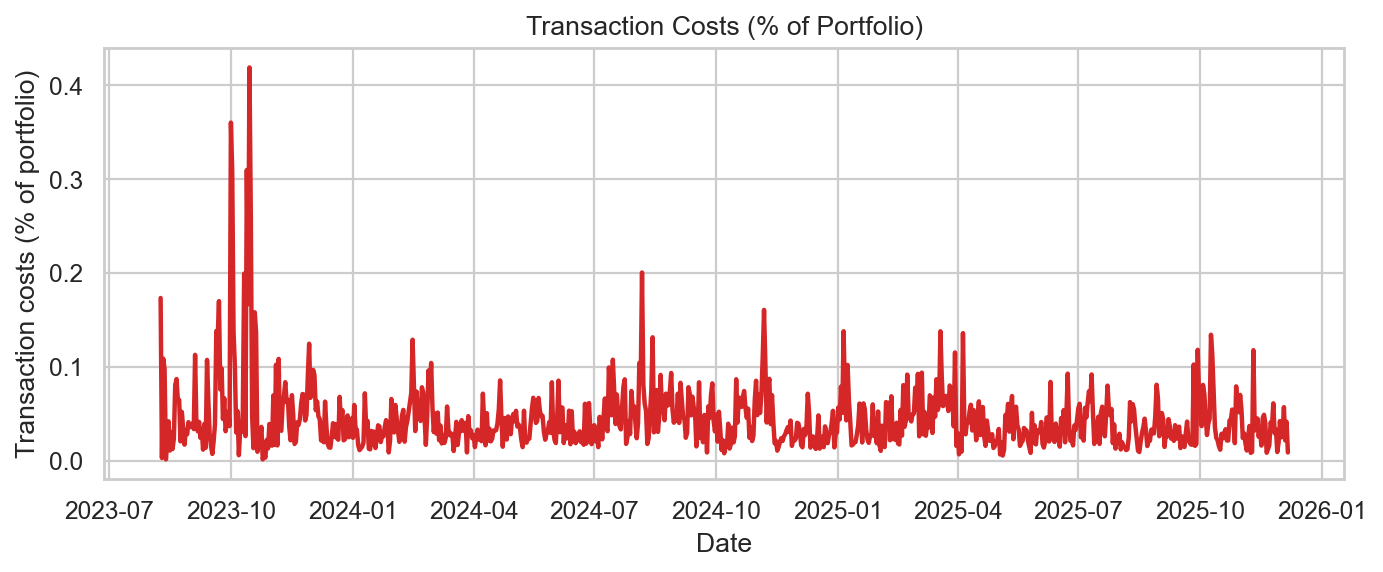
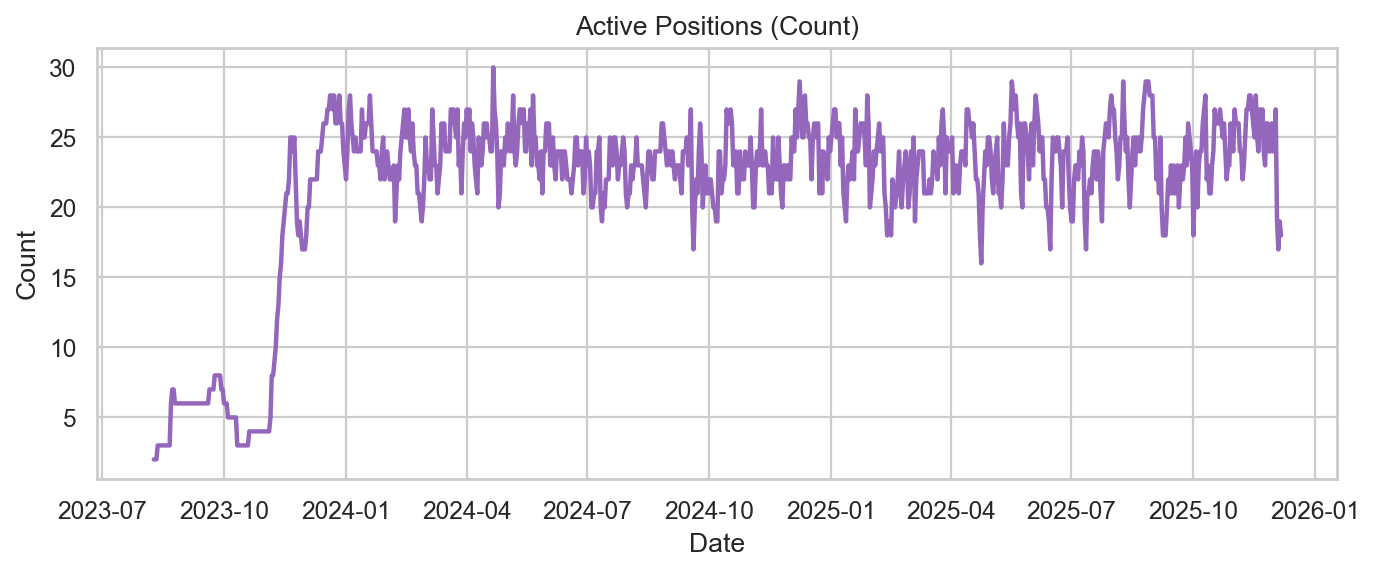
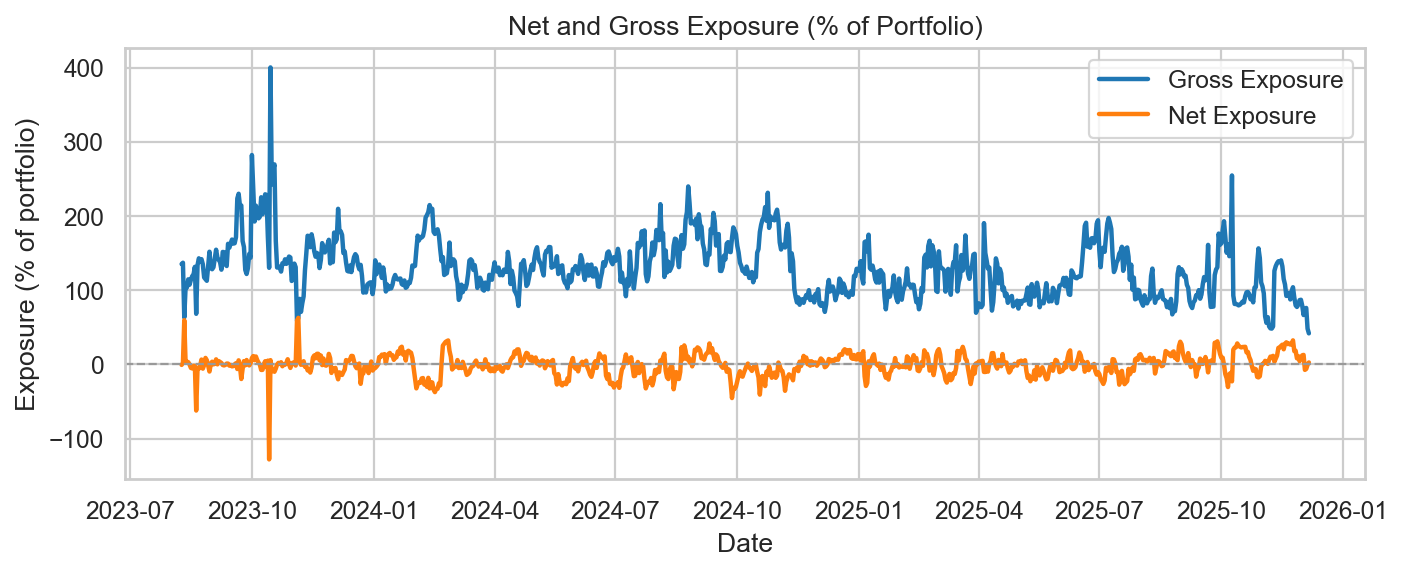
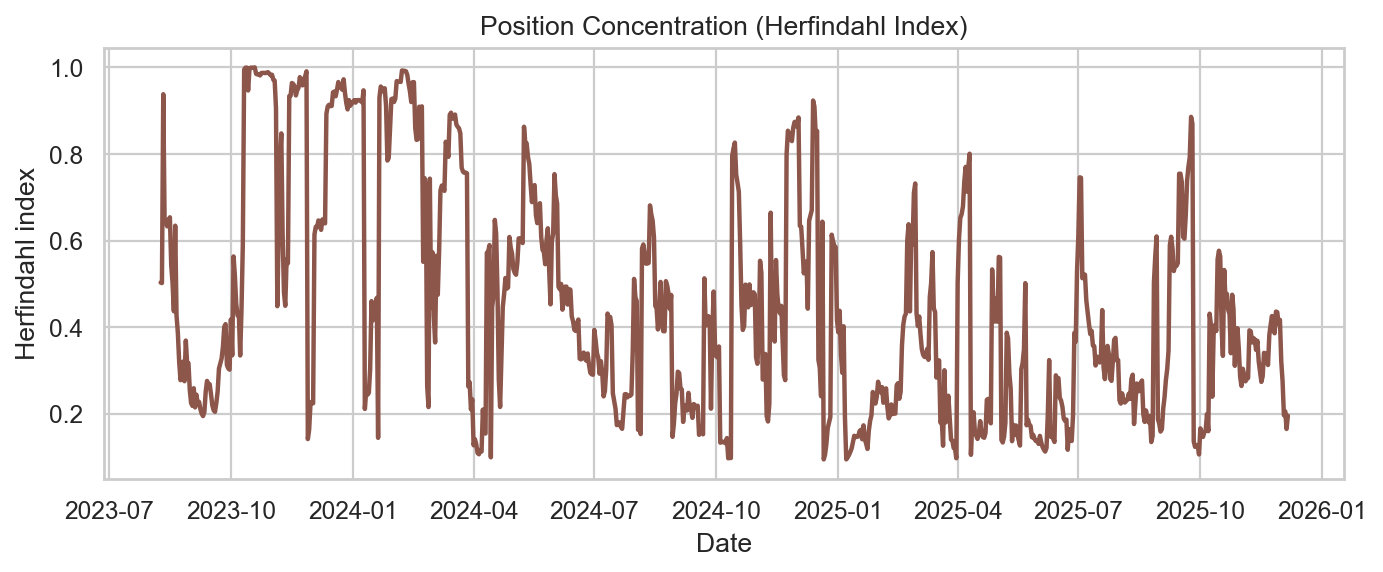
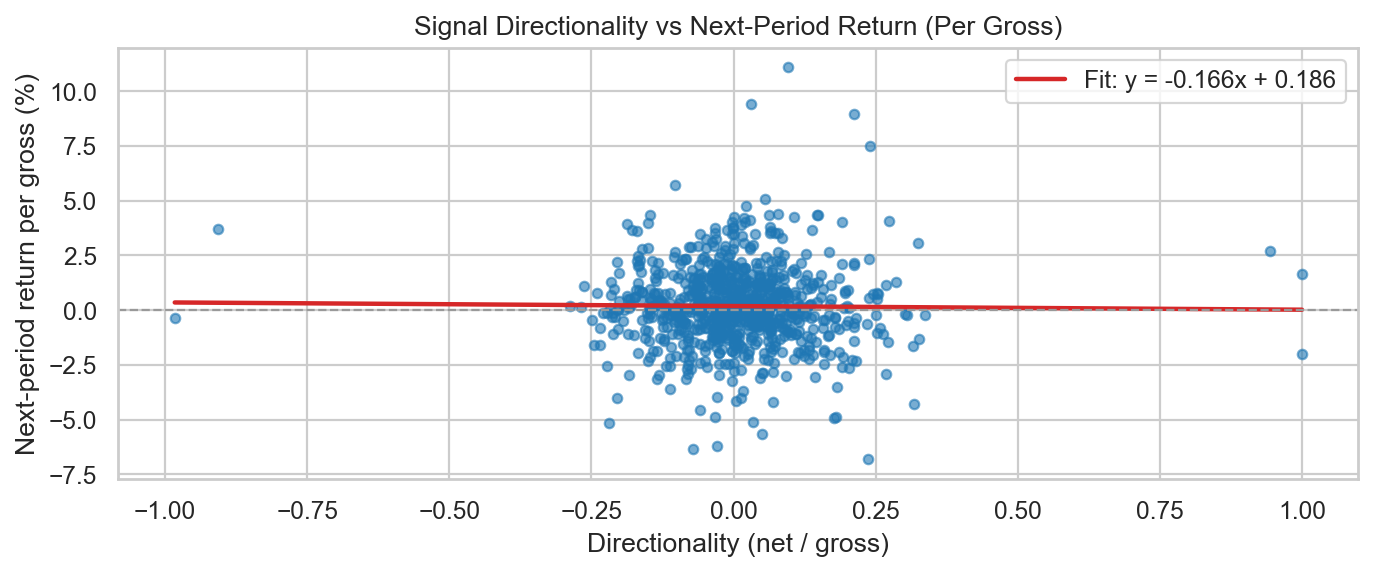
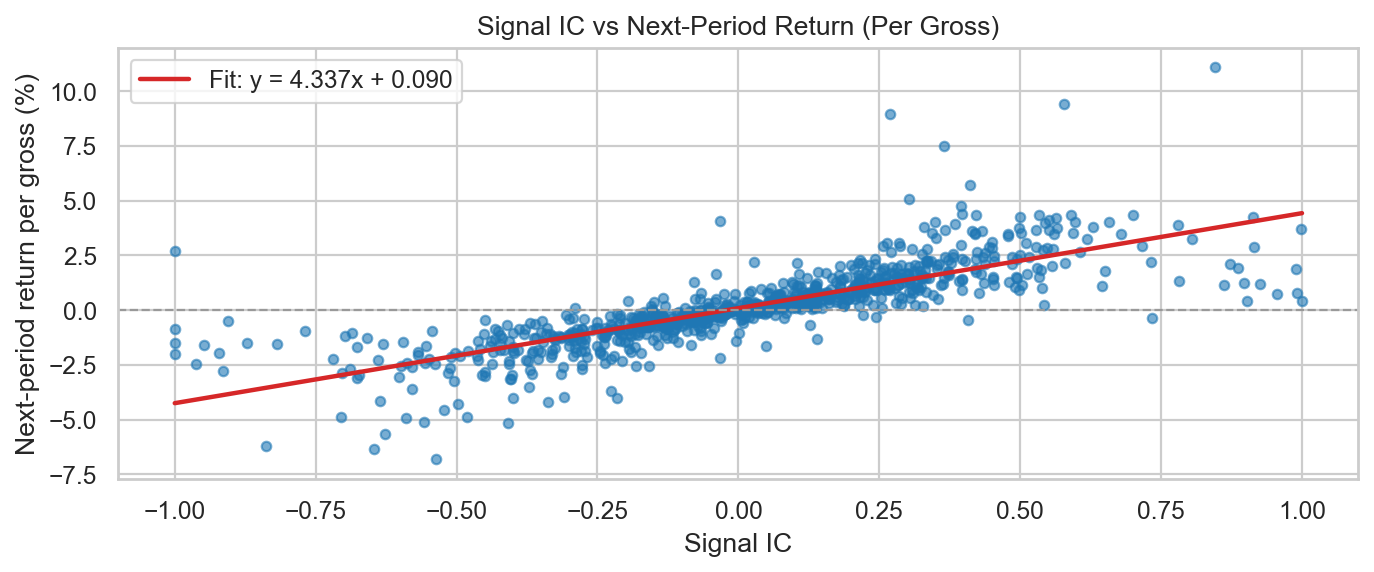
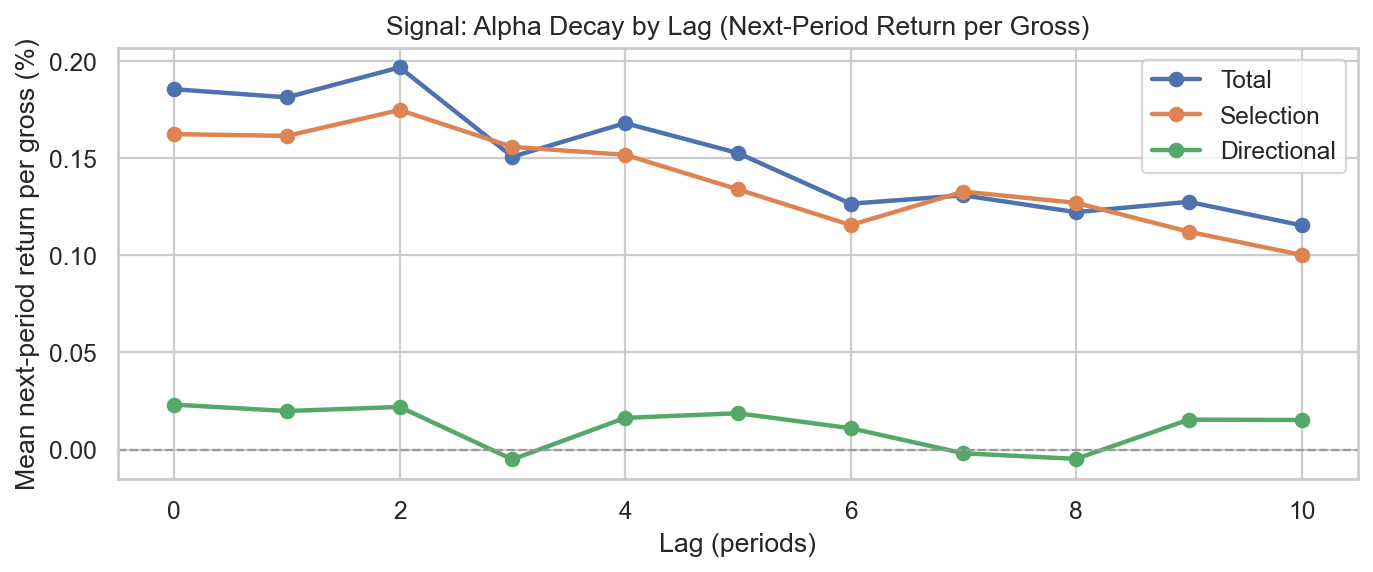
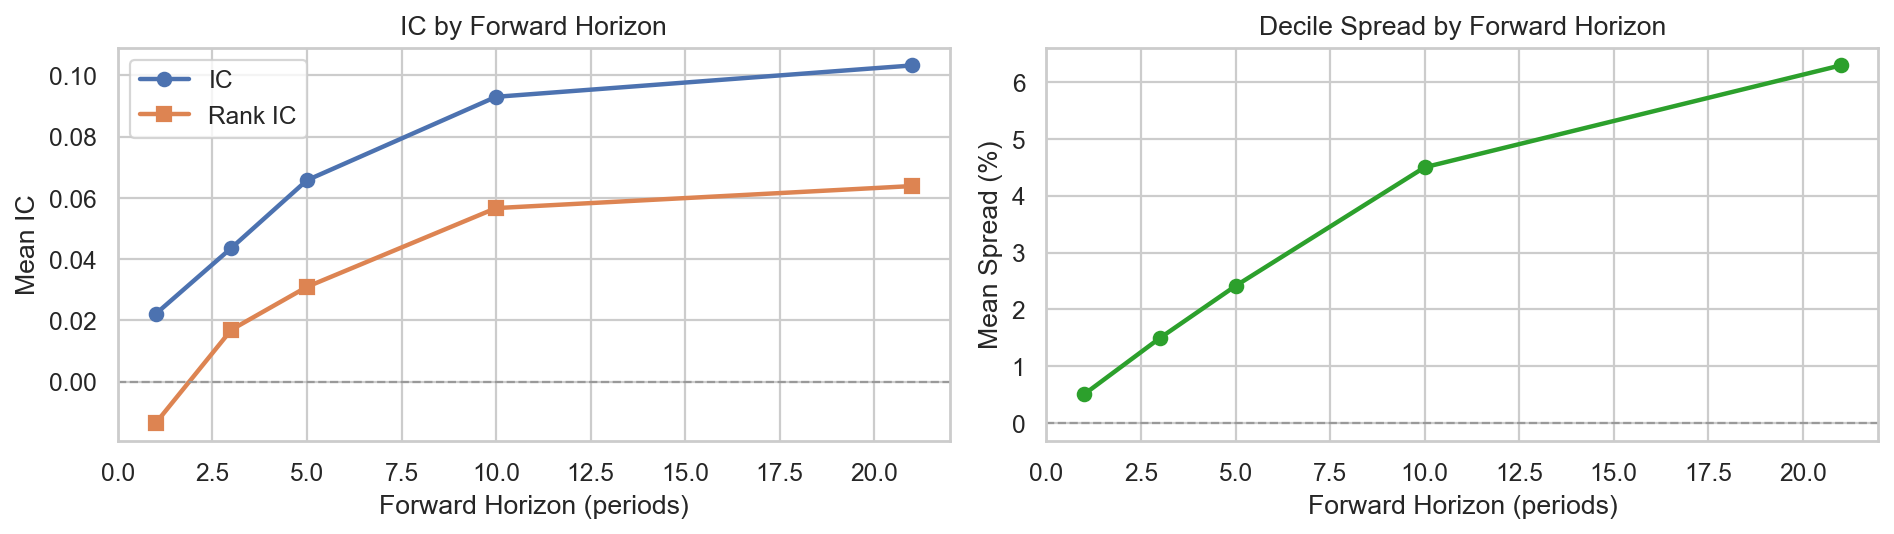
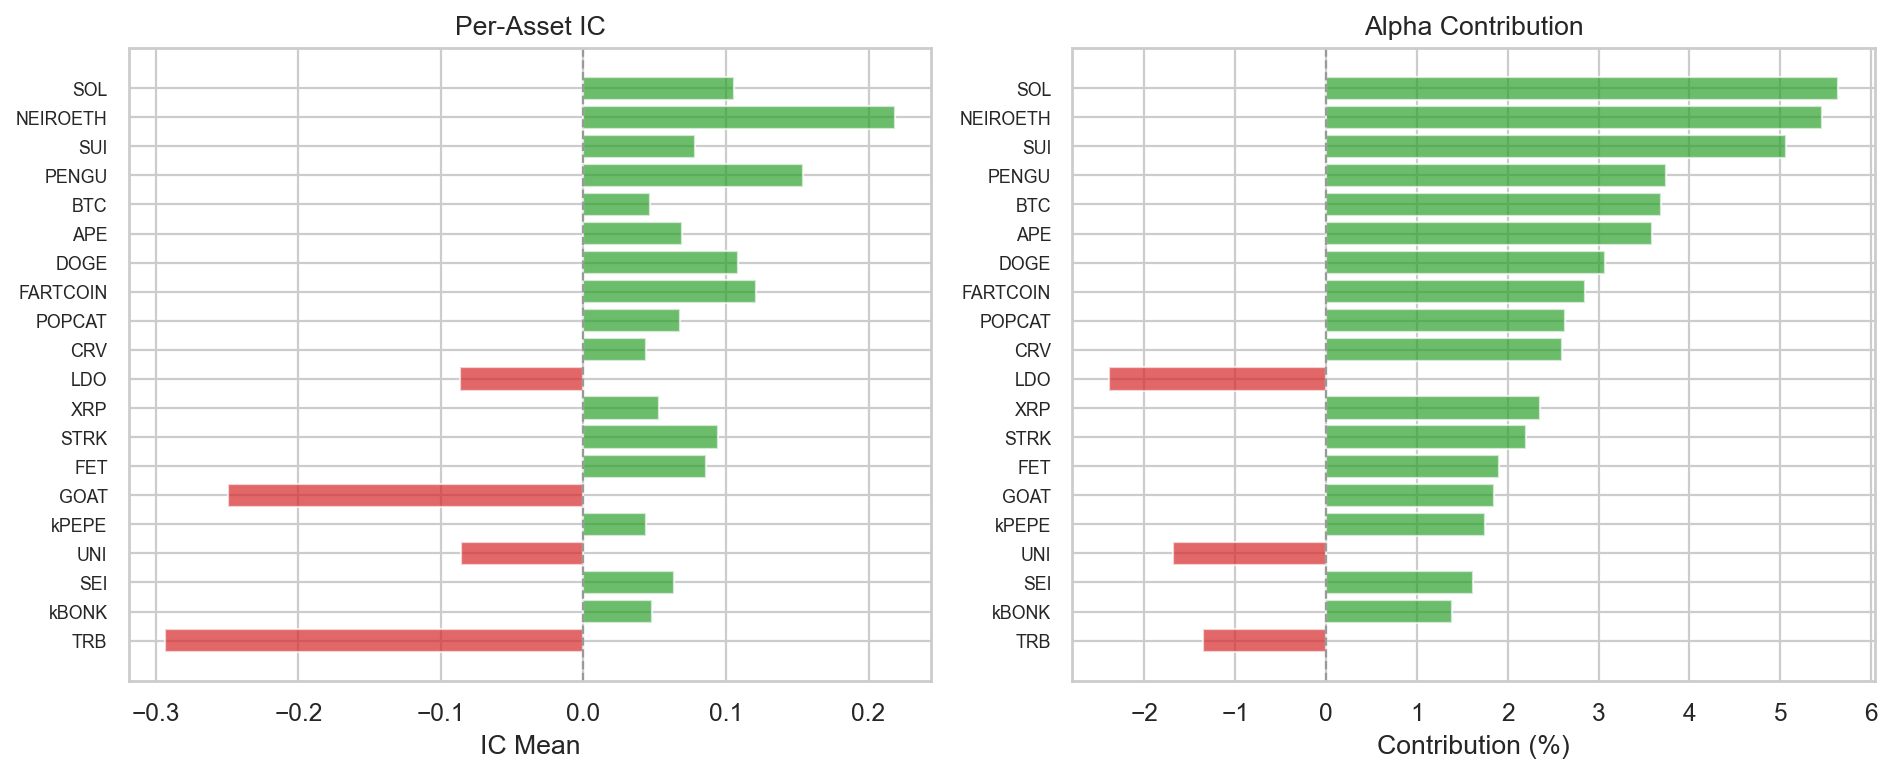
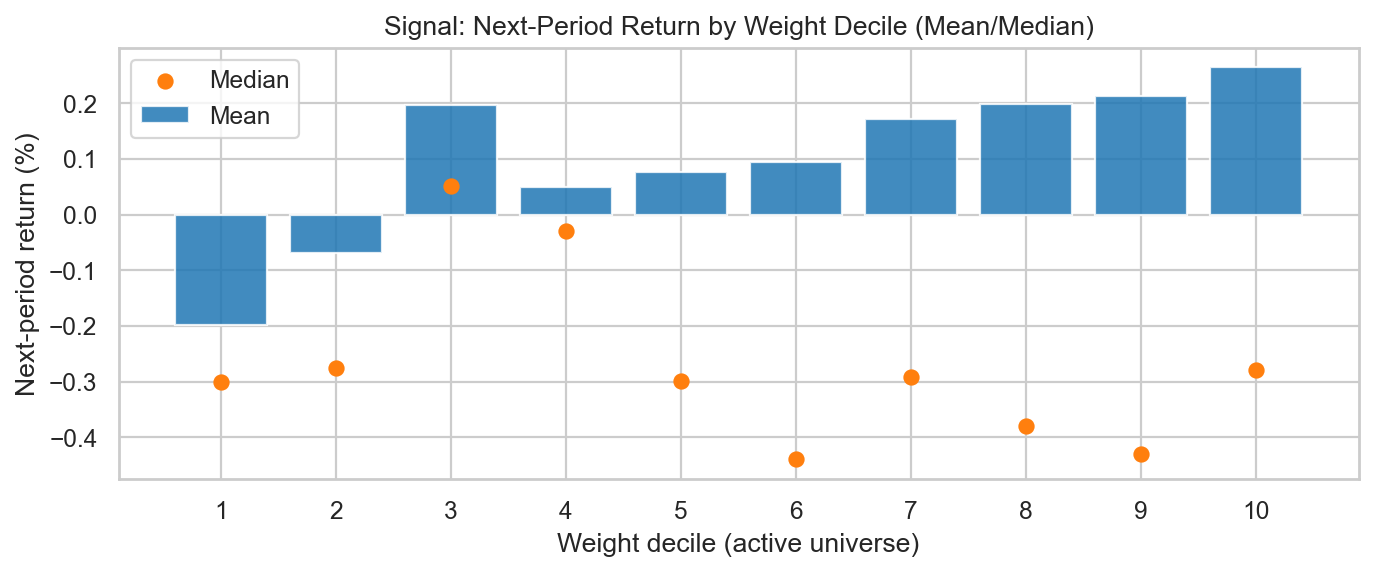
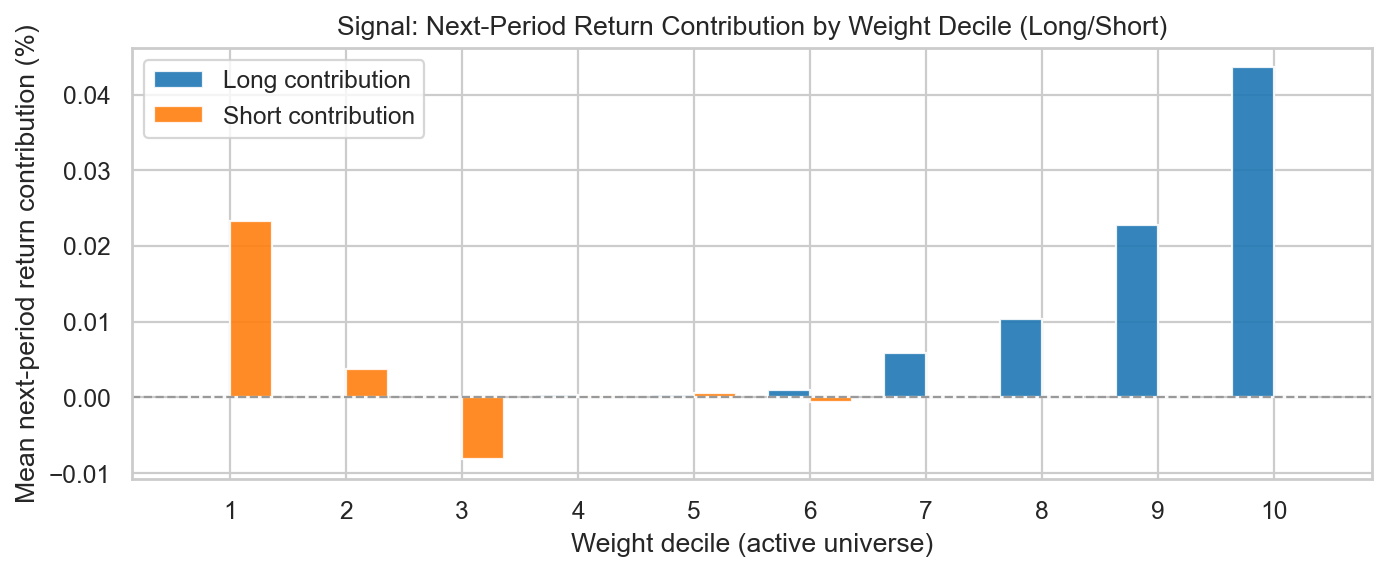

In [10]:
# Generate tearsheet for the full simulation period
html_str = tearsheet(sim_result=result.full_result, output_path="walk_forward_full_tearsheet.html")
display(HTML(html_str))

Best fold: 8 (2025-08-31 to 2025-11-29)


,Category,Value,Note
Metric,,,
Period frequency,Meta,1D,Interpretation: Sampling frequency used for annualization. Smaller periods are generally more granular (but can be noisier).
Benchmark Asset,Meta,BTC,Interpretation: Column name of the benchmark asset used for alpha/beta and benchmark charts (if provided).
Fee %,Meta,0.00025,Interpretation: Trading fee rate applied to order notional (decimal units; e.g. 0.001 = 10 bps).
Slippage %,Meta,0.001,Interpretation: Slippage applied against the trader on execution prices (decimal units; e.g. 0.001 = 10 bps).
Init Cash,Meta,10000.0,Interpretation: Initial cash (starting equity) used for the simulation.
Trading Days Year,Meta,365,Interpretation: Trading days per year used for annualization.
Risk Free Rate,Meta,0.03,Interpretation: Annual risk-free rate used for Sharpe/Sortino (decimal units).
Simulation start date,Meta,2025-08-31 00:00:00+00:00,Interpretation: First timestamp in the simulation index. Earlier start dates generally make estimates more statistically stable.
Simulation end date,Meta,2025-11-29 00:00:00+00:00,Interpretation: Last timestamp in the simulation index. More recent end dates generally better reflect current market conditions.

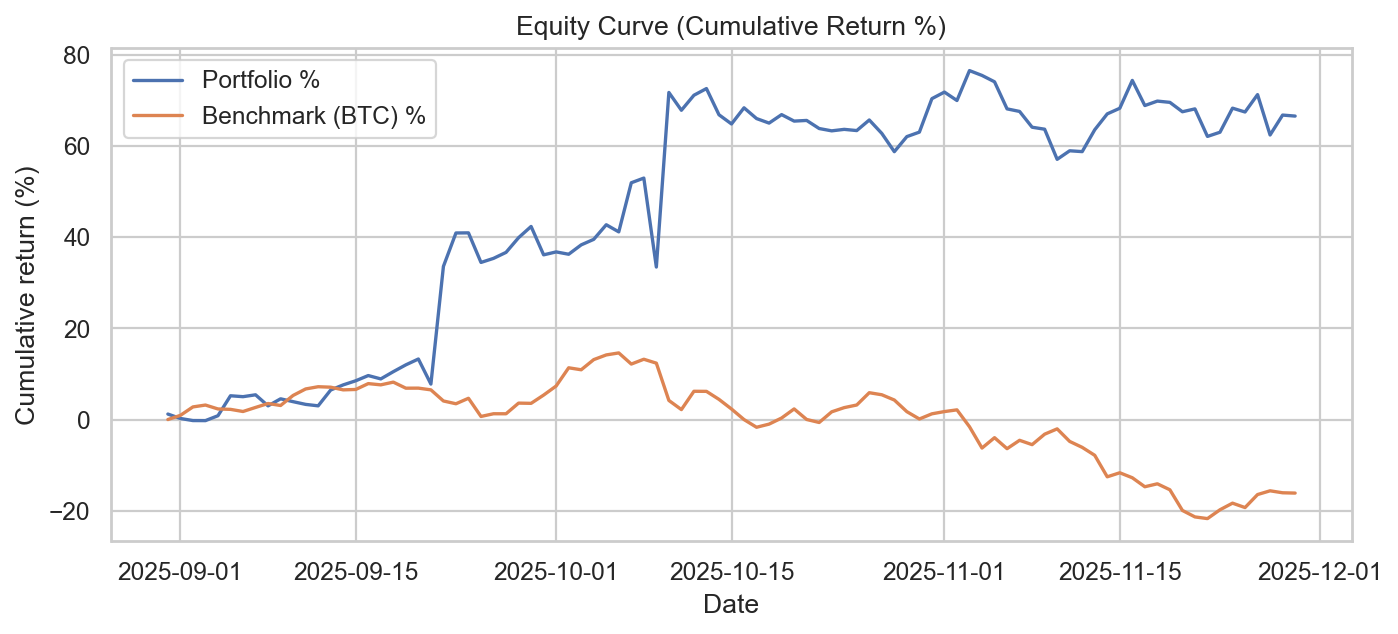
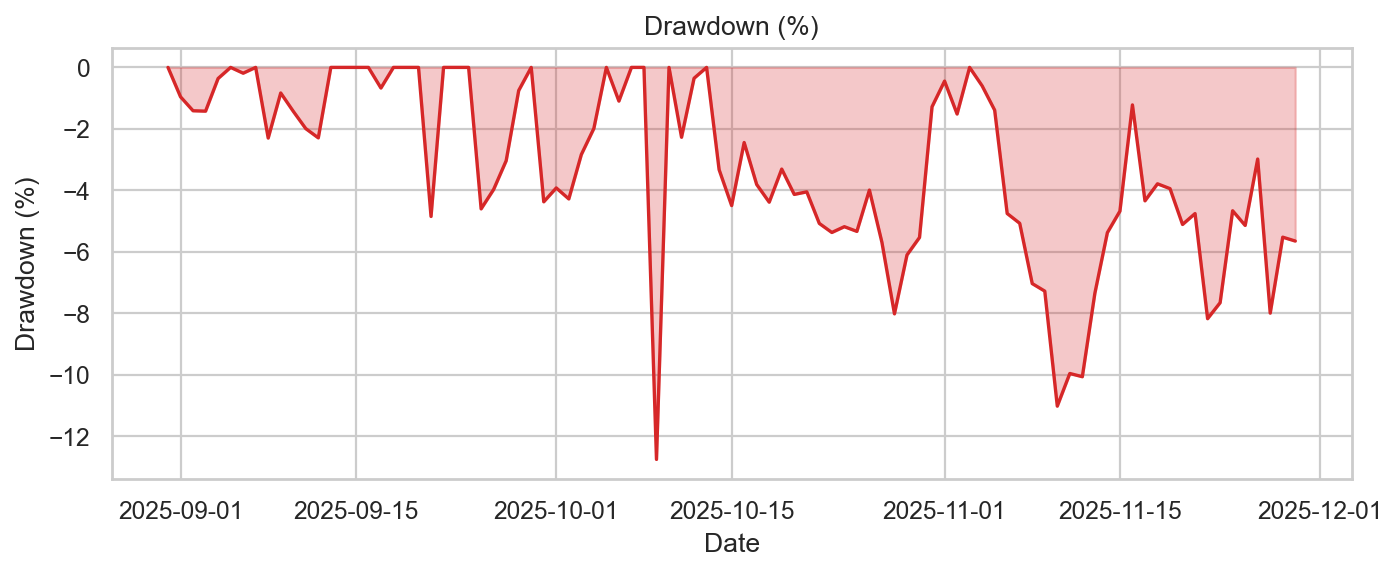
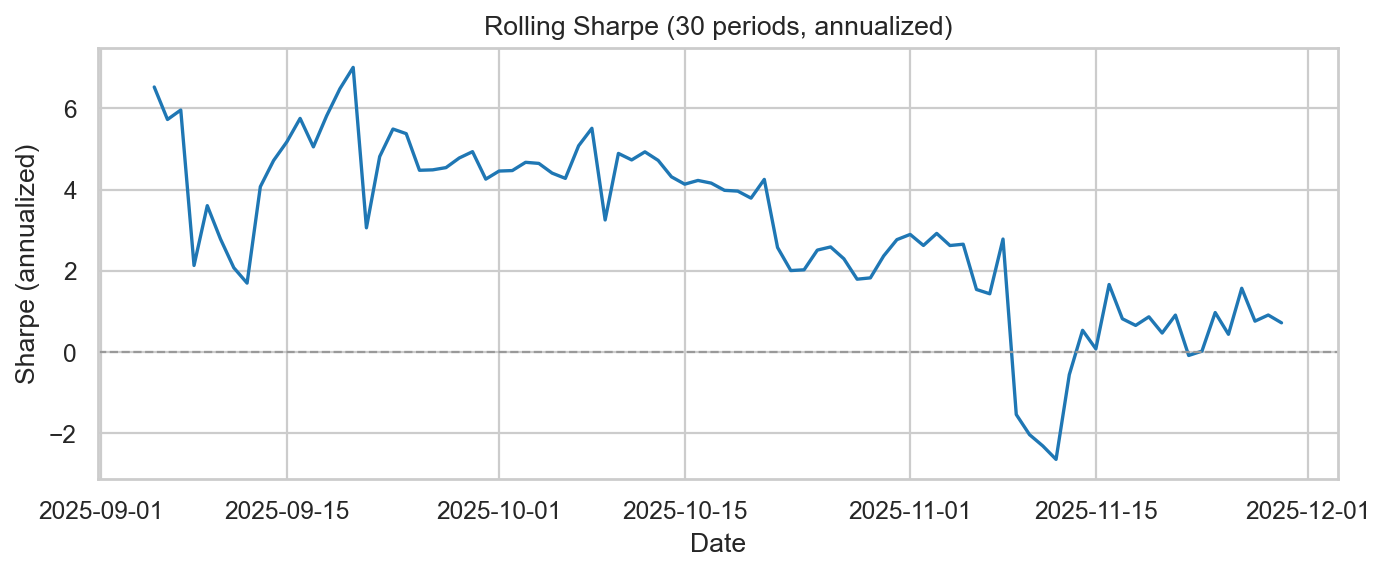
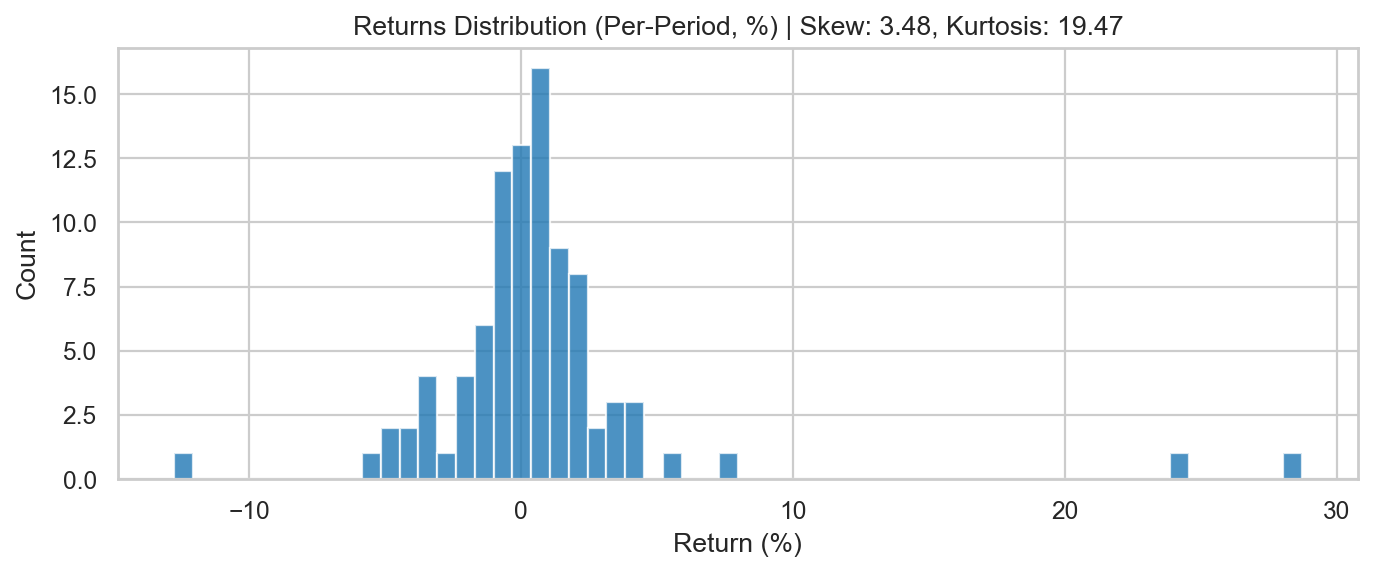
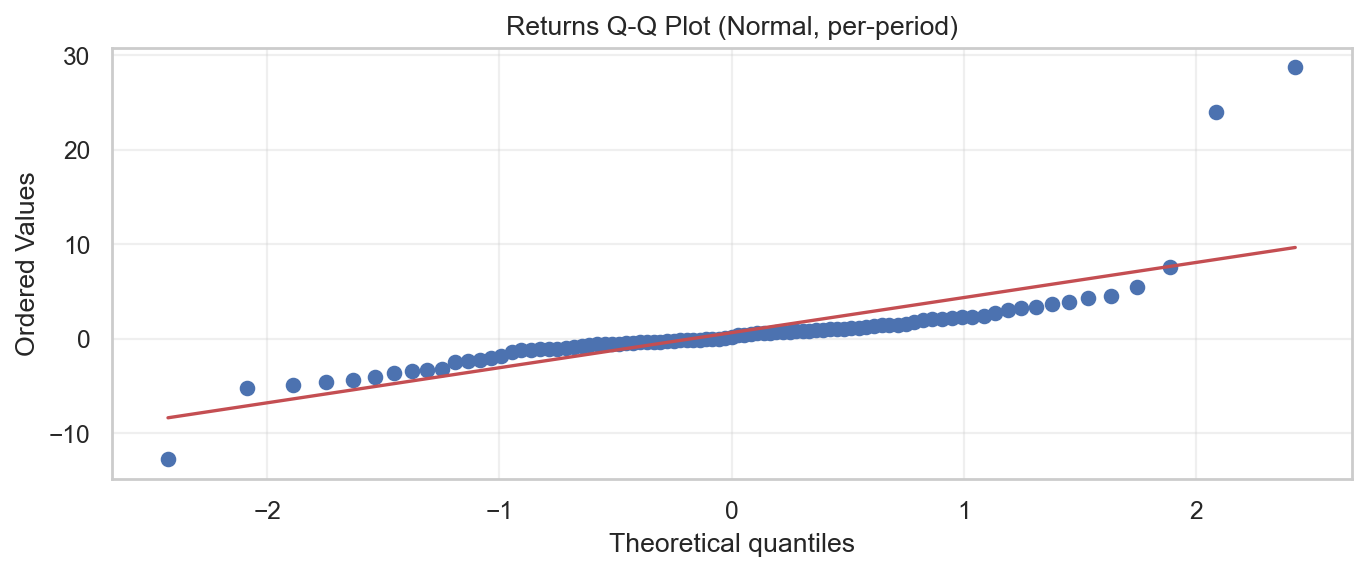
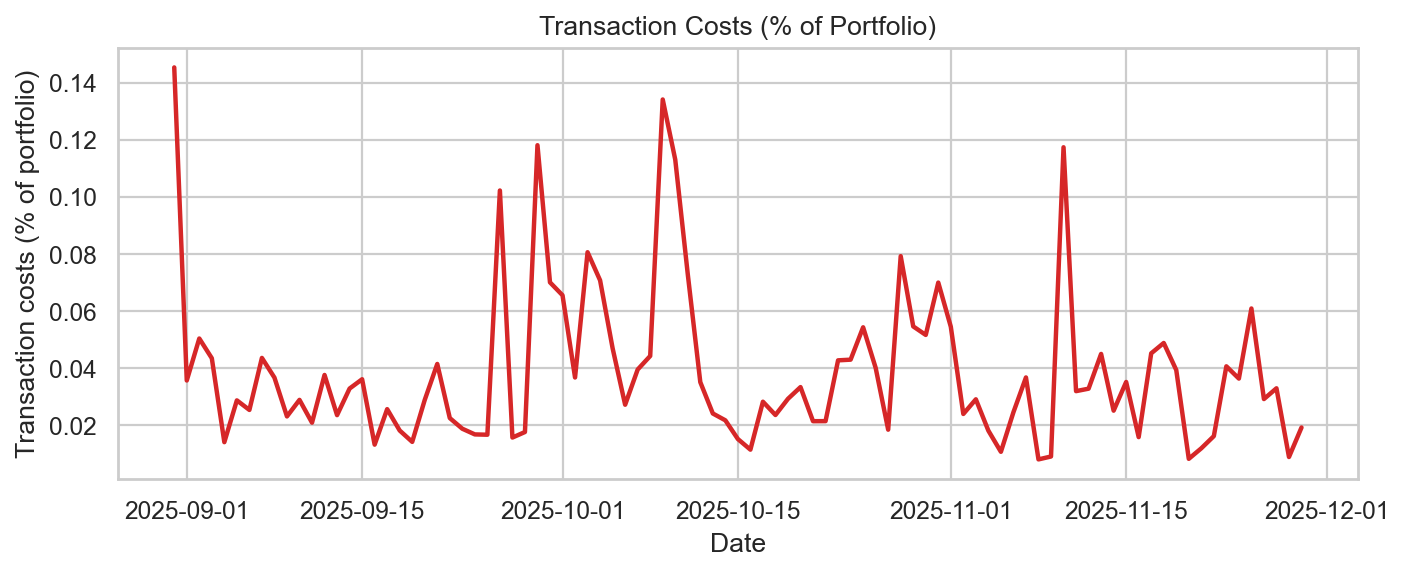
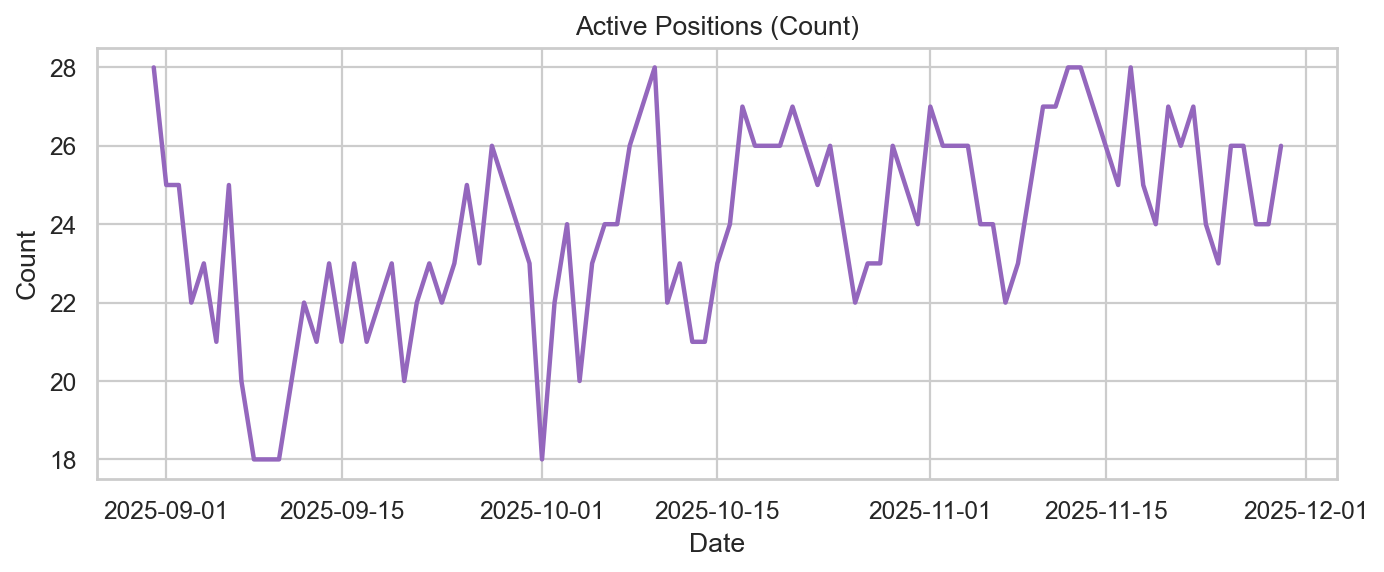
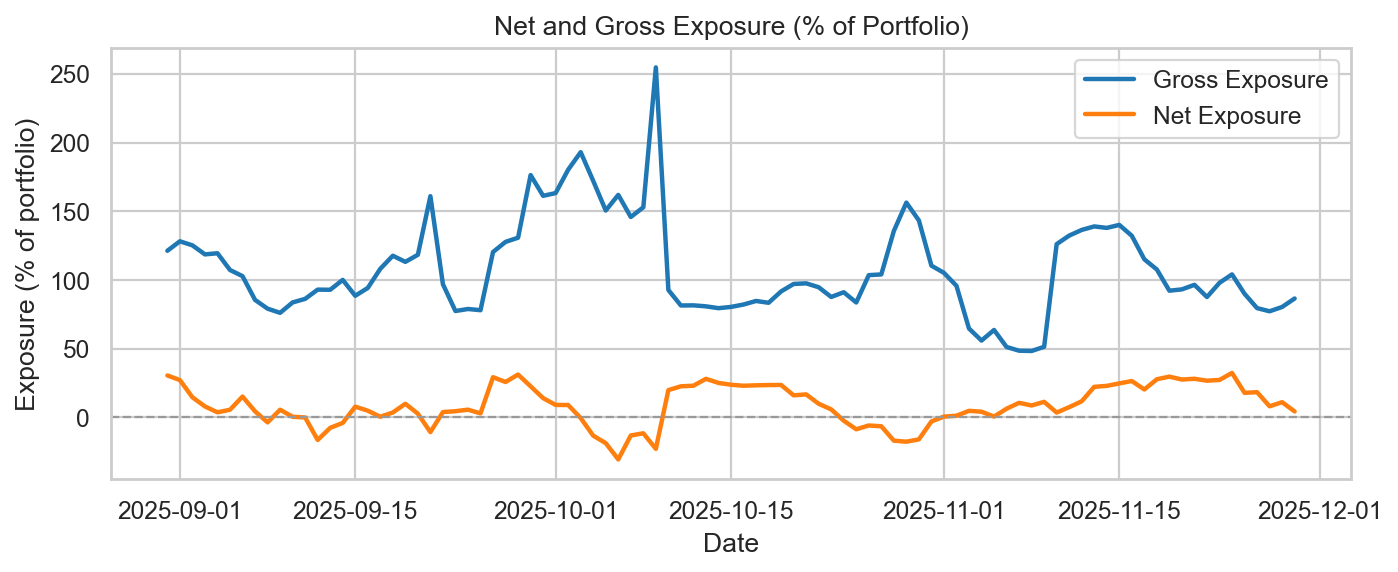
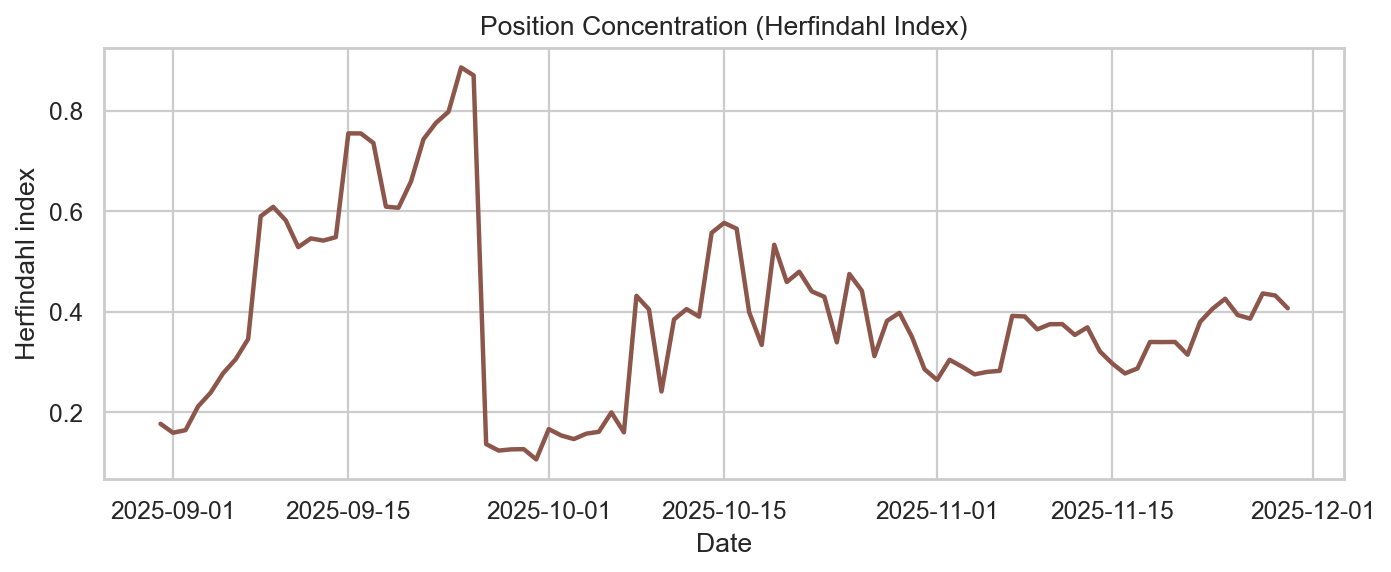
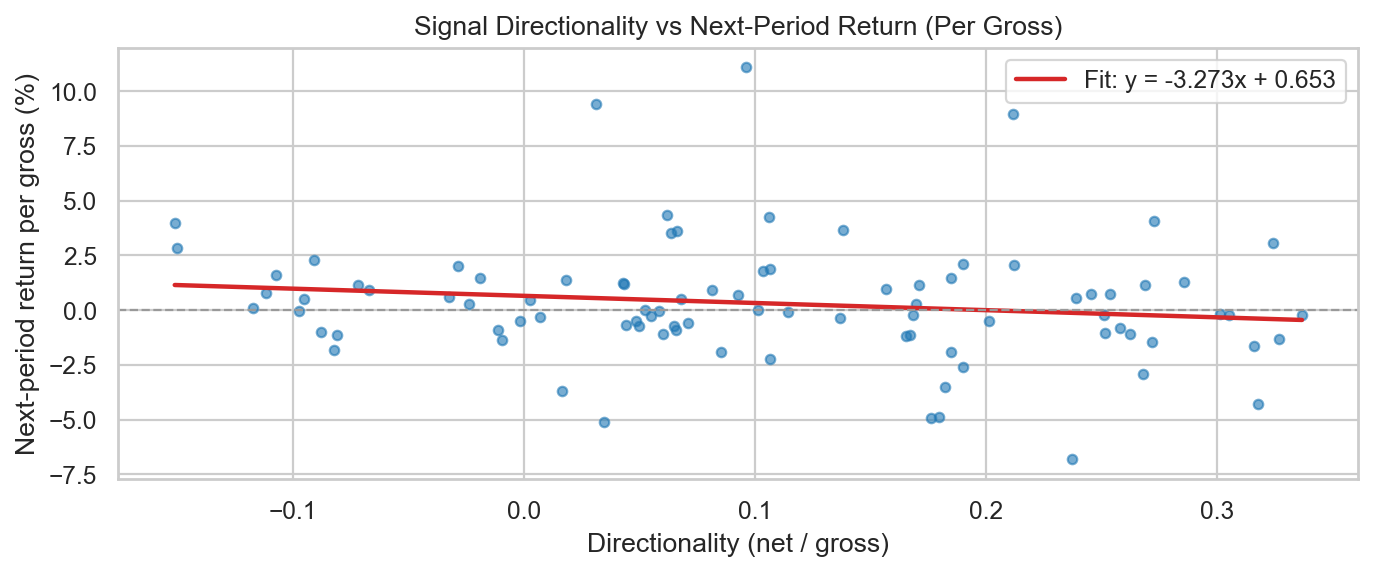
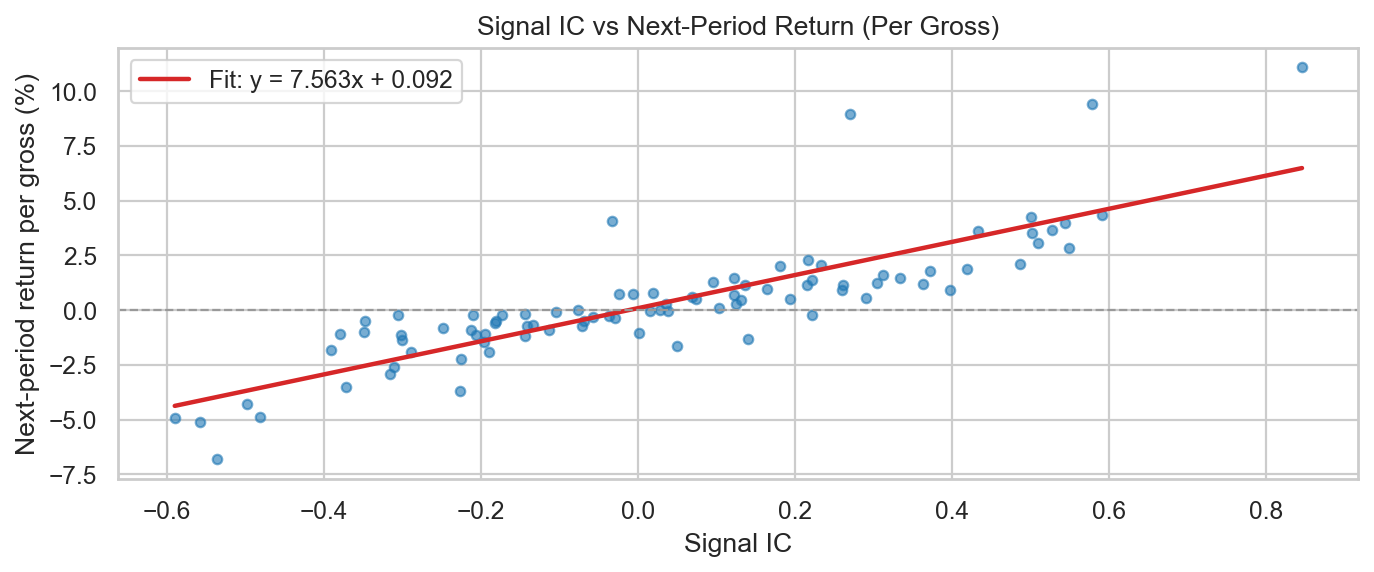
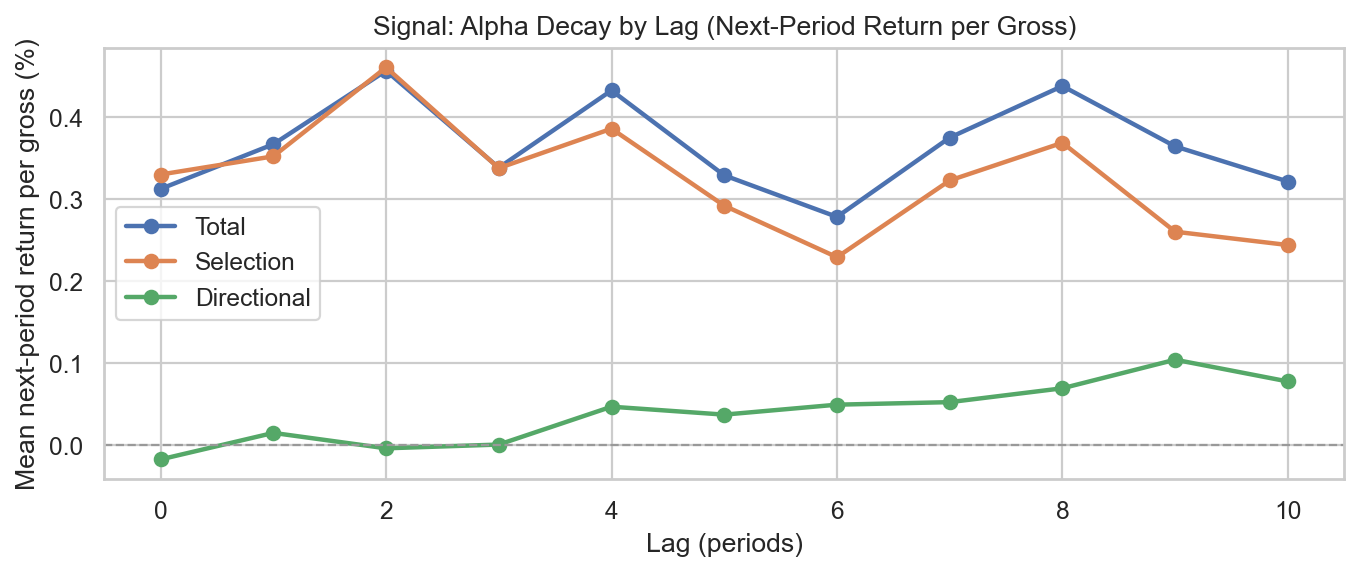
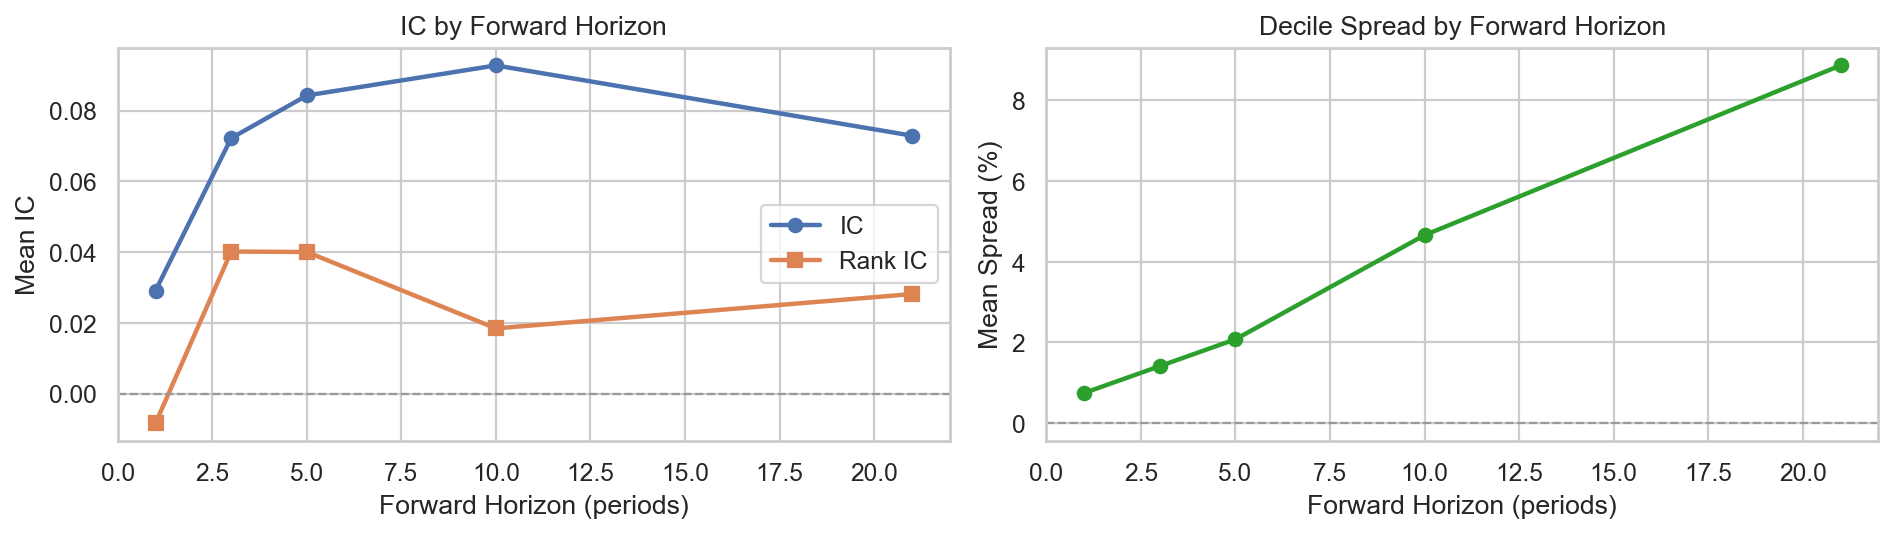
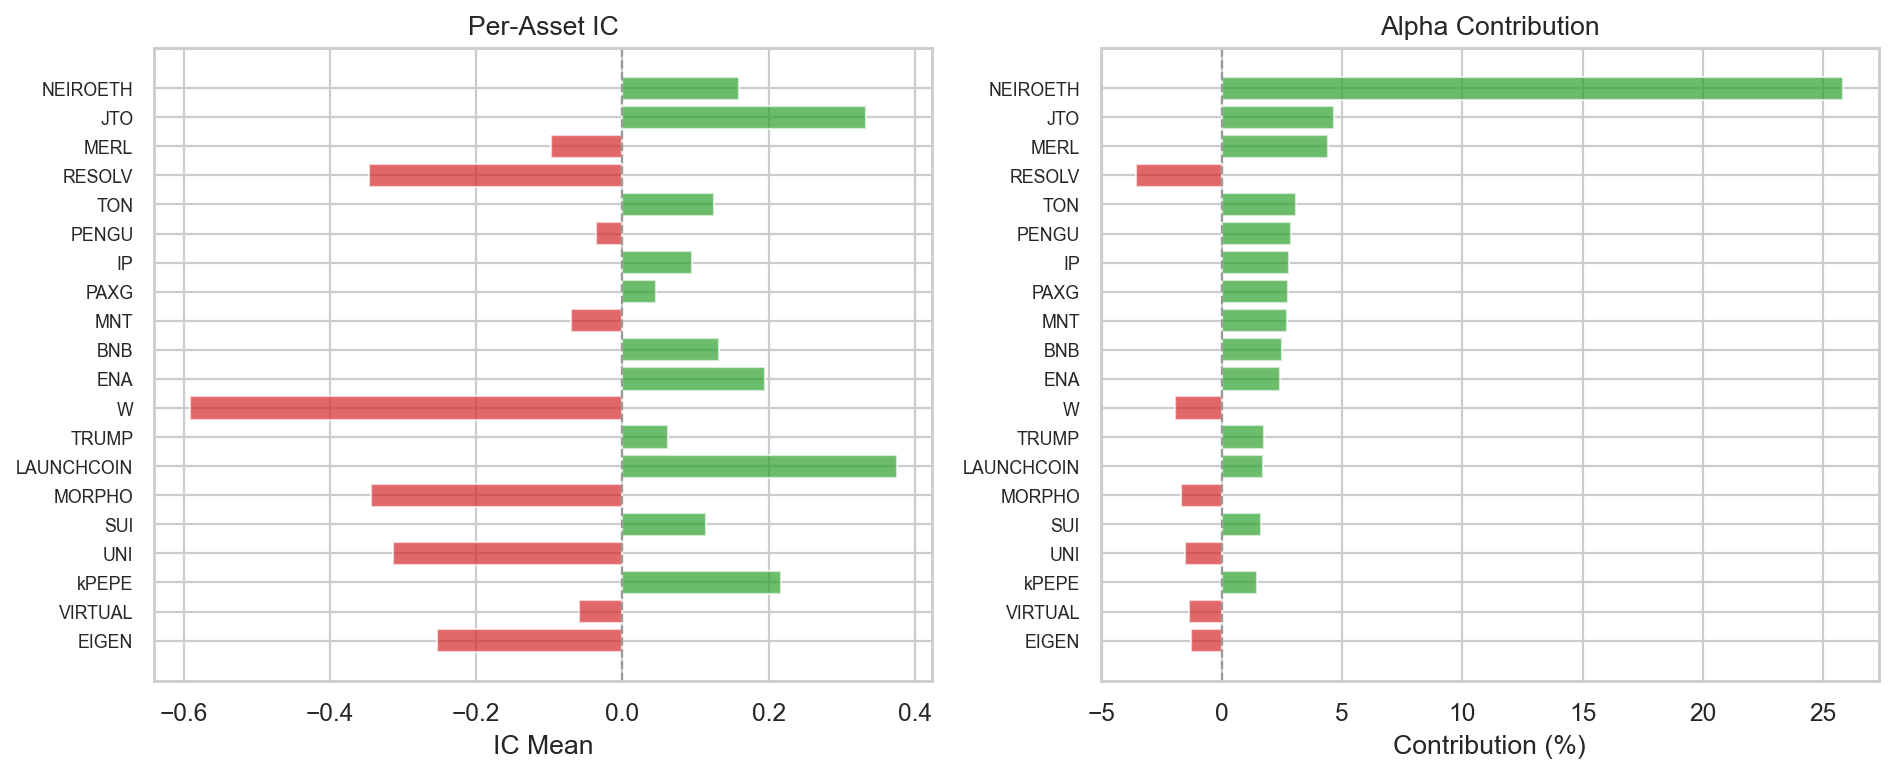
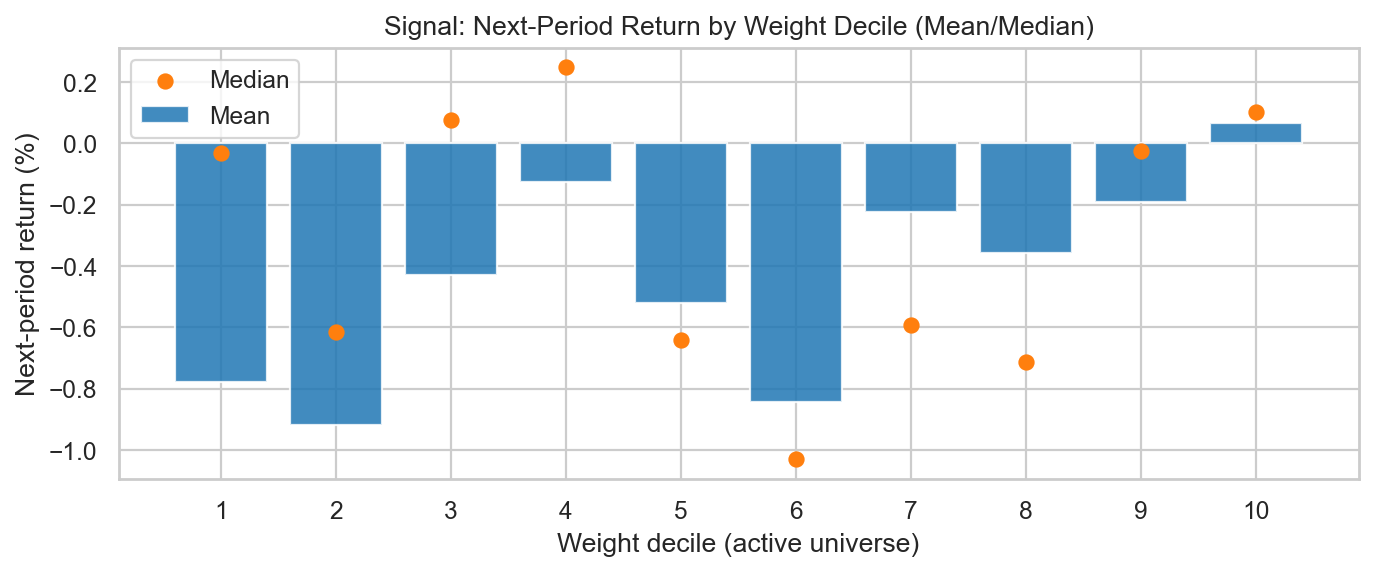
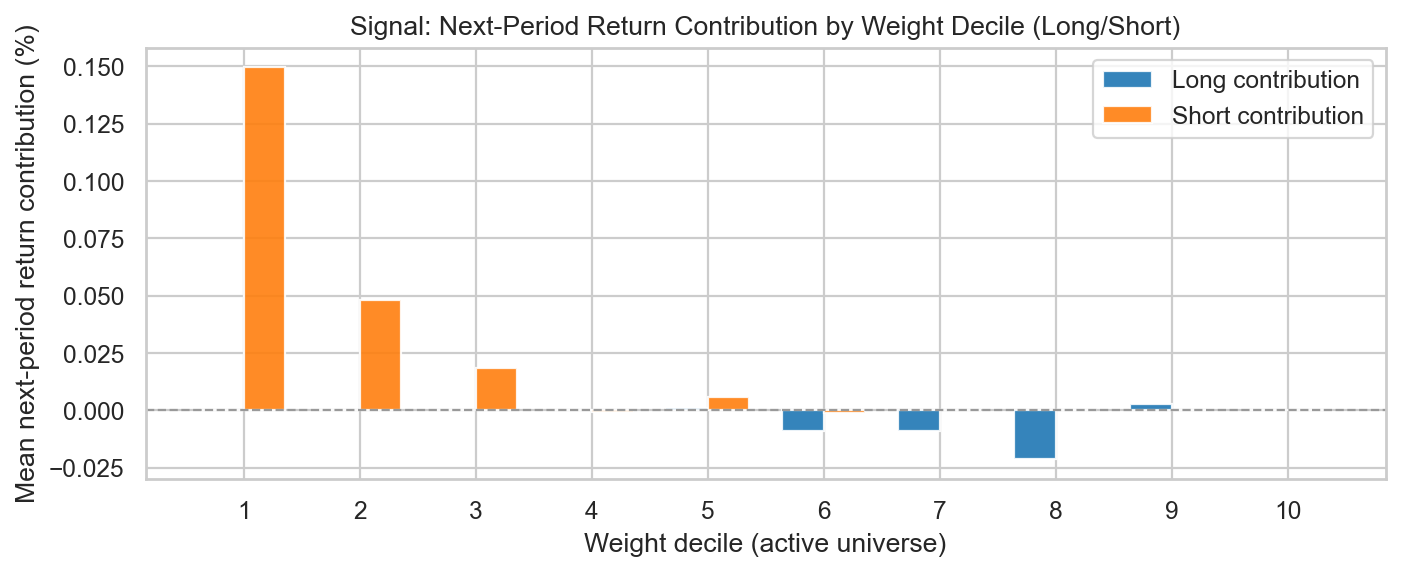

In [11]:
# Generate tearsheet for the best-performing fold (by Sharpe ratio)
best_fold_idx = fold_sharpes.idxmax()
best_fold = result.folds[best_fold_idx]
print(f"Best fold: {best_fold_idx} ({best_fold.start_period.strftime('%Y-%m-%d')} to {best_fold.end_period.strftime('%Y-%m-%d')})")

html_str = tearsheet(sim_result=best_fold.result, output_path=f"walk_forward_fold_{best_fold_idx}_tearsheet.html")
display(HTML(html_str))